In [1]:
# Cell 1: Imports and load dataset
import pandas as pd
import numpy as np
from pathlib import Path

df = pd.read_csv('netflix_customer_churn.csv')
df.head()

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


In [2]:
# Cell 2: Quick info
df.info()
df.describe(include='all').T
print("Missing values:\n", df.isnull().sum())
print("Target distribution:\n", df['churned'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             5000 non-null   object 
 1   age                     5000 non-null   int64  
 2   gender                  5000 non-null   object 
 3   subscription_type       5000 non-null   object 
 4   watch_hours             5000 non-null   float64
 5   last_login_days         5000 non-null   int64  
 6   region                  5000 non-null   object 
 7   device                  5000 non-null   object 
 8   monthly_fee             5000 non-null   float64
 9   churned                 5000 non-null   int64  
 10  payment_method          5000 non-null   object 
 11  number_of_profiles      5000 non-null   int64  
 12  avg_watch_time_per_day  5000 non-null   float64
 13  favorite_genre          5000 non-null   object 
dtypes: float64(3), int64(4), object(7)
memor

In [3]:
# Cell 3: Drop id and fix column names (if needed)
if 'customer_id' in df.columns:
    df = df.drop(columns=['customer_id'])

# Standardize column names (optional)
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
df.head()

,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


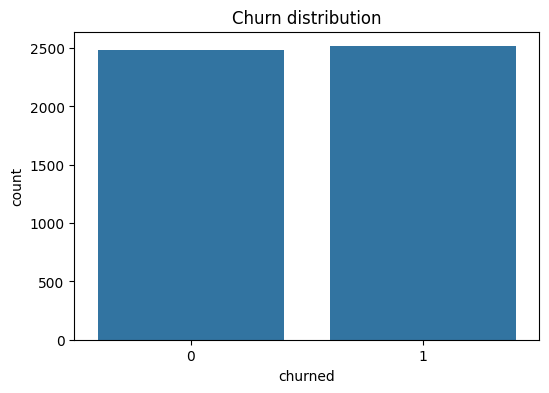

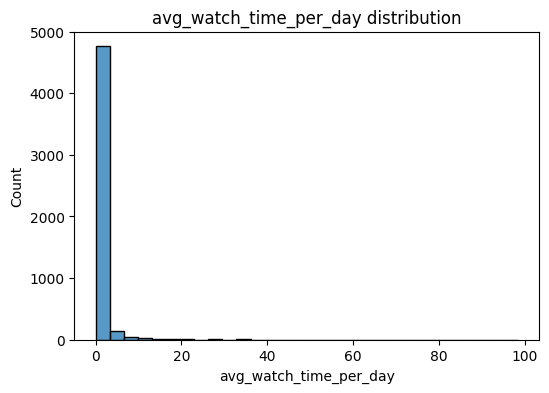

In [4]:
# Cell 4: Visual EDA (matplotlib/seaborn)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='churned', data=df)
plt.title('Churn distribution')
plt.show()

# distribution of avg_watch_time_per_day
plt.figure(figsize=(6,4))
sns.histplot(df['avg_watch_time_per_day'].dropna(), bins=30)
plt.title('avg_watch_time_per_day distribution')
plt.show()

In [5]:
# Cell 5: Example feature engineering (tenure buckets, engagement flags)
# If you have 'watch_hours' and 'avg_watch_time_per_day'
df['low_engagement'] = (df['avg_watch_time_per_day'] < df['avg_watch_time_per_day'].median()).astype(int)

# bucket tenure if there's plan_duration or similar numeric column
# df['tenure_bucket'] = pd.cut(df['plan_duration'], bins=[0,3,12,36,100], labels=['0-3','3-12','12-36','36+'])

df[['avg_watch_time_per_day','low_engagement']].head()

,avg_watch_time_per_day,low_engagement
0,0.49,0
1,0.03,1
2,1.48,0
3,0.35,0
4,0.13,1


In [6]:
# Cell 6: Features and target split
target = 'churned'
X = df.drop(columns=[target])
y = df[target]

# identify numeric and categorical
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()

numeric_features, cat_features

(['age',
  'watch_hours',
  'last_login_days',
  'monthly_fee',
  'number_of_profiles',
  'avg_watch_time_per_day',
  'low_engagement'],
 ['gender',
  'subscription_type',
  'region',
  'device',
  'payment_method',
  'favorite_genre'])

In [8]:
# Cell 7: Training with pipelines, SMOTE, RF & XGBoost comparison (corrected)

# Imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from pathlib import Path

# Paths
ROOT = Path.cwd().parent  # adjust if your notebook root differs
MODEL_DIR = ROOT / 'model'
ASSETS_DIR = ROOT / 'assets'
MODEL_DIR.mkdir(exist_ok=True)
ASSETS_DIR.mkdir(exist_ok=True)

# Ensure X, y, numeric_features, cat_features exist from earlier cells.
# If not, run the earlier cells that define them.
print("Num features:", numeric_features)
print("Cat features:", cat_features)

# Preprocessing pipelines
numeric_transformer = SkPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Use sparse_output for sklearn >=1.4 compatibility
if len(cat_features) > 0:
    categorical_transformer = SkPipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, cat_features)
    ])
else:
    # If no categorical features, use only numeric transformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Train/test split (keep test untouched)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Build imblearn pipelines with SMOTE applied during training only
rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1))
])

# Parameter grids (small grid for speed — expand later if needed)
param_grid_rf = {'clf__n_estimators': [100, 200], 'clf__max_depth': [None, 10]}
param_grid_xgb = {'clf__n_estimators': [100, 200], 'clf__max_depth': [3, 6]}

# Grid search for Random Forest
print("Grid searching RandomForest...")
grid_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

# Grid search for XGBoost
print("Grid searching XGBoost...")
grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)

# Evaluation helper
def eval_grid(grid, X_test, y_test, name):
    best = grid.best_estimator_
    y_proba = best.predict_proba(X_test)[:, 1]
    y_pred = best.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    print(f"\n--- {name} ---")
    print("Best params:", grid.best_params_)
    print("Accuracy:", acc)
    print("ROC AUC:", roc)
    print(classification_report(y_test, y_pred))
    return best, y_proba, acc, roc

best_rf, rf_proba, rf_acc, rf_roc = eval_grid(grid_rf, X_test, y_test, "RandomForest")
best_xgb, xgb_proba, xgb_acc, xgb_roc = eval_grid(grid_xgb, X_test, y_test, "XGBoost")

# Choose best by ROC AUC
if xgb_roc >= rf_roc:
    best_model = best_xgb
    best_name = "XGBoost"
    best_proba = xgb_proba
else:
    best_model = best_rf
    best_name = "RandomForest"
    best_proba = rf_proba

print(f"\nSelected best model: {best_name}")

# Save the best pipeline (it includes preprocessing + SMOTE + model)
joblib.dump(best_model, MODEL_DIR / 'model_pipeline.pkl')
print("Saved model pipeline to", MODEL_DIR / 'model_pipeline.pkl')

# Feature importance extraction (if model exposes feature_importances_)
# Get feature names after preprocessing
preproc = best_model.named_steps['preprocessor']
num_names = numeric_features
cat_names = []
if len(cat_features) > 0:
    # get ohe feature names safely
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    cat_names = list(ohe.get_feature_names_out(cat_features))
feature_names = num_names + cat_names

# model is the classifier step
clf = best_model.named_steps['clf']
if hasattr(clf, 'feature_importances_'):
    importances = clf.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top15 = feat_imp.head(15)

    # Save feature importance as Plotly HTML + PNG
    fig = px.bar(x=top15.values, y=top15.index, orientation='h', title=f"Top Features ({best_name})")
    fig.update_layout(xaxis_title='Importance', yaxis={'autorange':'reversed'})
    fig.write_html(ASSETS_DIR / 'feature_importance.html')
    try:
        fig.write_image(str(ASSETS_DIR / 'feature_importance.png'))  # requires kaleido
    except Exception as e:
        print("Could not save feature_importance.png (kaleido may be missing):", e)
else:
    print("Classifier has no feature_importances_ attribute; skipping feature importance export.")

# ROC curve (save as html + png)
fpr, tpr, _ = roc_curve(y_test, best_proba)
roc_fig = go.Figure()
roc_fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC'))
roc_fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', name='Random', line=dict(dash='dash')))
roc_fig.update_layout(title=f'ROC Curve ({best_name})', xaxis_title='FPR', yaxis_title='TPR')
roc_fig.write_html(ASSETS_DIR / 'roc_curve.html')
try:
    roc_fig.write_image(str(ASSETS_DIR / 'roc_curve.png'))
except Exception as e:
    print("Could not save roc_curve.png (kaleido may be missing):", e)

# Save short summary CSV
summary = pd.DataFrame({
    'metric': ['rf_acc','rf_roc','xgb_acc','xgb_roc','selected_model'],
    'value': [rf_acc, rf_roc, xgb_acc, xgb_roc, best_name]
})
summary.to_csv(ASSETS_DIR / 'model_summary.csv', index=False)

print("Saved assets to", ASSETS_DIR)

Num features: ['age', 'watch_hours', 'last_login_days', 'monthly_fee', 'number_of_profiles', 'avg_watch_time_per_day', 'low_engagement']
Cat features: ['gender', 'subscription_type', 'region', 'device', 'payment_method', 'favorite_genre']
Grid searching RandomForest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Grid searching XGBoost...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/anaconda3/envs/practice/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:05:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/practice/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:05:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/practice/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:05:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/practice/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:05:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_en


--- RandomForest ---
Best params: {'clf__max_depth': None, 'clf__n_estimators': 200}
Accuracy: 0.976
ROC AUC: 0.9981399330375893
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       497
           1       0.98      0.97      0.98       503

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


--- XGBoost ---
Best params: {'clf__max_depth': 6, 'clf__n_estimators': 200}
Accuracy: 0.995
ROC AUC: 0.9998359940957875
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       497
           1       1.00      0.99      1.00       503

    accuracy                           0.99      1000
   macro avg       0.99      1.00      0.99      1000
weighted avg       1.00      0.99      1.00      1000


Selected best model: XGBoost
Saved model pipeline to /Users/dracksnoop/practice_python/model/

In [ ]:
!pip install imbalanced-learn

In [ ]:
pip show imbalanced-learn

In [ ]:
!pip install xgboost

In [ ]:
pip show xgboost

In [ ]:
!pip install plotly kaleido

In [9]:
# Cell 8: Quick test using saved pipeline
import joblib
model = joblib.load(MODEL_DIR / 'model_pipeline.pkl')
print("Loaded model:", model)

# take 3 random rows (without target)
sample = df.drop(columns=['churned']).sample(3, random_state=42)
preds = model.predict(sample)
probs = model.predict_proba(sample)[:,1]
sample['pred_churn'] = preds
sample['churn_prob'] = probs
sample

Loaded model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'watch_hours',
                                                   'last_login_days',
                                                   'monthly_fee',
                                                   'number_of_profiles',
                                                   'avg_watch_time_per_day',
                                                   'low_engagement']),
                                                 ('cat',
                                                  Pipeline(steps

,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre,low_engagement,pred_churn,churn_prob
1501,39,Other,Basic,9.96,22,South America,Tablet,8.99,Gift Card,5,0.43,Drama,0,0,5.185785e-03
2586,18,Female,Standard,0.25,37,Africa,Laptop,13.99,Debit Card,5,0.01,Sci-Fi,1,1,9.991804e-01
2653,19,Female,Standard,8.54,6,Africa,TV,13.99,Credit Card,3,1.22,Romance,0,0,4.294938e-08


In [10]:
# notebook cell — run in your Jupyter notebook (where df exists)
import json
from pathlib import Path

ROOT = Path.cwd().parent  # adjust if needed so it points to project root
ASSETS_DIR = ROOT / "assets"
ASSETS_DIR.mkdir(exist_ok=True)

# compute the median exactly as used when creating 'low_engagement'
median_val = df['avg_watch_time_per_day'].median()
metadata = {"avg_watch_time_per_day_median": float(median_val)}

# save
with open(ASSETS_DIR / "metadata.json", "w") as f:
    json.dump(metadata, f)

print("Saved median:", median_val, "to", ASSETS_DIR / "metadata.json")

Saved median: 0.29 to /Users/dracksnoop/practice_python/assets/metadata.json
